In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from scipy.stats import sem
import matplotlib.cm as cm
from configs import engram_dir

# Helper functions

In [2]:
from sklearn.metrics import auc

In [3]:
def plot(
    df, plot_key, plot_ep, figsize=(6.4*0.75, 4.8*0.75),
    fnames=None, figname=None, labels=None,
    smooth_plot=True, smooth_plot_n=2, colors=None,
    legend_title=None, ylim=None, plot_title=None, show_legend=True,
    plot_auc=False, ylabel='Avg Episode Score', xlim=None):
    
    fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)
    zs = np.sort(np.unique(df['z']))
    episode = np.sort(np.unique(df['episode']))
    if fnames is None:
        fnames = np.unique(df['model'])
    for fname_idx, fname in enumerate(fnames):
        line = []
        shading_width = []
        shading_lower = []
        shading_upper = []
        for z in zs:
            df_subset = df[(df['model']==fname) & (df['z']==z)]
            if plot_auc:
                aucs = []
                for file in np.unique(df_subset['file']):
                    df_file_subset = df_subset[df_subset['file']==file]
                    episodes = np.array(df_file_subset['episode'])
                    vals = np.array(df_file_subset[plot_key])
                    aucs.append(auc(episodes, vals)/episodes.max())
                auc_mean = np.mean(aucs)
                auc_sem = sem(aucs)
                line.append(auc_mean)
                shading_width.append(auc_sem)
            else:
                means = []
                sems = []
                val_len = 0
                for ep in episode:
                    vals = df_subset[df_subset['episode']==ep]
                    vals = vals[plot_key]
                    means.append(np.mean(vals))
                    sems.append(sem(vals))
                    if ep == plot_ep:
                        val_len = len(vals)
                means = np.array(means)
                sems = np.array(sems)
                if z == 5:
                    print(fname)
                    print(f'Mean: {means[plot_ep]}, SEM: {sems[plot_ep]} for {val_len} vals')
                line.append(means[plot_ep])
                shading_width.append(sems[plot_ep])
        if smooth_plot:
            _line = smooth(zs, line, smooth_plot_n)
            _shading_width = smooth(zs, shading_width, smooth_plot_n)
            line = np.array(_line)
            shading_lower = line - _shading_width
            shading_upper = line + _shading_width
        x_axis = zs
        if colors is not None:
            color = colors[fname_idx]
        else:
            color = None
        if labels != None:
            label = fname_labels[fname_idx]
        else:
            label = fname
        ax.plot(x_axis, line, label=label, color=color, alpha=0.8)
        ax.fill_between(x_axis, shading_lower, shading_upper, alpha=0.2,color=color)
    plt.xlabel('Latent Dimensions')
    if show_legend: plt.legend(title=legend_title)
    if ylabel != None:
        plt.ylabel(ylabel)
    if ylim != None:
        plt.ylim(ylim[0], ylim[1])
    if xlim != None:
        plt.xlim(xlim[0], xlim[1])
    if plot_title != None:
        plt.title(plot_title)
    plt.xlabel('Latent Size')
    if figname != None:
        plt.savefig(figname + '.png', dpi=300, transparent=True)
    plt.show()

In [4]:
def smooth(xs, ys, n=3):
    vals = np.copy(ys)
    smoothed = np.convolve(ys, np.ones(n)/n, mode='same')
    vals[1:-1] = smoothed[1:-1]
    return vals

In [5]:
def get_df(base, zs, net_yaml):
    data = {
        'valid_score': [], 'valid_steps':[], 'dims': [],
        'episode': [], 'model': [], 'z': [], 'step': [], 'file': []}
    for z in zs:
        task_dir = f'{base}_{net_yaml}_dim{z}'
        task_dir = f'{engram_dir}pickles/{task_dir}/'
        if not os.path.exists(task_dir): continue
        for pickle_file in os.listdir(task_dir):
            if not pickle_file.endswith('.p'): continue
            pickle_file = f'{task_dir}{pickle_file}'
            with open(pickle_file, 'rb') as f:
                results = pickle.load(f)
            valid_score = results['valid_score']
            valid_steps = results['valid_steps_per_ep']
            episode = results['episode']
            model = results['model']
            step = results['step']
            for i in range(len(valid_score)):
                if valid_score[i] == None: continue
                data['valid_score'].append(valid_score[i])
                data['valid_steps'].append(valid_steps[i])
                data['dims'].append(z)
                data['episode'].append(episode[i])
                _model = model[i].split(base+'_')[-1]
                data['model'].append(_model)
                data['z'].append(z)
                data['step'].append(step[i])
                data['file'].append(pickle_file)
    df = pd.DataFrame(data)
    return df

# Initial Gridworld Experiments

In [6]:
zs = np.arange(2, 13)

In [7]:
recalculate = False
if recalculate:
    task_df = get_df('new_gridworld8x8_shuffobs', zs, 'dm')
    with open('pickles/new_gridworld8x8_shuffobs.p', 'wb') as f:
        pickle.dump(task_df, f)
else:
    with open('pickles/new_gridworld8x8_shuffobs.p', 'rb') as f:
        task_df = pickle.load(f)

mf0
Mean: 0.7866666666666666, SEM: 0.06673559654894302 for 30 vals
entro0
Mean: 0.8166666666666667, SEM: 0.05007656972326521 for 30 vals
g0_-2_entro-1
Mean: 0.9666666666666667, SEM: 0.033333333333333326 for 30 vals


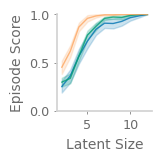

In [9]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    task_df, 'valid_score', 600, figsize=(1.5, 1.5),
    fnames=['mf0', 'entro0', 'g0_-2_entro-1'],
    smooth_plot=True, smooth_plot_n=2,
    figname='1e', colors=['C0', 'C2', colors(c_steps[0])],
    show_legend=False, plot_title='', ylim=(0,1), ylabel='Episode Score'
    )

# Effect of Large Q

In [6]:
zs = np.arange(2, 22)

In [18]:
recalculate = False
if recalculate:
    task_df = get_df('new_gridworld8x8_shuffobs', zs, 'dm_large_q')
    with open('pickles/s2_large_q.p', 'wb') as f:
        pickle.dump(task_df, f)
else:
    with open('pickles/s2_large_q.p', 'rb') as f:
        task_df = pickle.load(f)

mf0
Mean: 0.82, SEM: 0.04534937327643742 for 45 vals
entro2
Mean: 0.882222222222222, SEM: 0.029178809401166194 for 45 vals
g0_-2_entro-1
Mean: 1.0, SEM: 0.0 for 45 vals


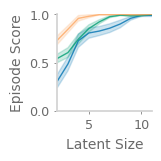

In [19]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    task_df, 'valid_score', 600, figsize=(1.5, 1.5),
    fnames=['mf0', 'entro2', 'g0_-2_entro-1'],
    smooth_plot=True, smooth_plot_n=2,
    figname='s1b', colors=['C0', 'C2', colors(c_steps[0])],
    show_legend=False, plot_title='', ylim=(0,1), ylabel='Episode Score',
    xlim=[2,11]
    )

# Effect of Large Encoder

In [11]:
zs = np.arange(2, 22)

In [13]:
recalculate = False
if recalculate:
    task_df = get_df('new_gridworld8x8_shuffobs', zs, 'dm_large_encoder')
    with open('pickles/s2_large_encoder.p', 'wb') as f:
        pickle.dump(task_df, f)
else:
    with open('pickles/s2_large_encoder.p', 'rb') as f:
        task_df = pickle.load(f)

mf1
Mean: 0.6466666666666665, SEM: 0.07607215771934321 for 30 vals
entro0
Mean: 0.8533333333333333, SEM: 0.036113910884685047 for 30 vals
g0_-2_entro-1
Mean: 0.9933333333333334, SEM: 0.006666666666666665 for 30 vals


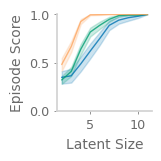

In [17]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    task_df, 'valid_score', 600, figsize=(1.5, 1.5),
    fnames=['mf1', 'entro0', 'g0_-2_entro-1',],
    smooth_plot=True, smooth_plot_n=2, figname='s1c',
    colors=['C0', 'C2', colors(c_steps[0])],
    show_legend=False, plot_title='', ylim=(0,1), ylabel='Episode Score'
    )